# ArXiv Supervised Classification: Overview and Findings

This notebook applies supervised machine learning techniques to classify arXiv papers into their appropriate scientific categories based on title and abstract text. The approach leverages PySpark's distributed computing capabilities to process over 2.6 million academic papers.

## Methodology

1. **Data Preparation**
   - Load and clean metadata (titles, abstracts, authors, categories) from 2.6M+ arXiv papers
   - Normalize text by removing whitespace, converting to lowercase, and splitting categories into arrays
   - Extract primary categories from papers with multiple category labels

2. **Feature Engineering**
   - Apply TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to create numerical features from text
   - Combine features from titles and abstracts to capture comprehensive document representation
   - Balance data processing performance through optimization techniques like repartitioning

3. **Model Implementation**
   - Train a multinomial logistic regression model with optimized hyperparameters
   - Configure model with enhanced regularization parameters, increased iterations, and improved convergence tolerance
   - Split data into training (80%) and testing (20%) sets for proper evaluation

## Key Findings

- **Overall Performance**: The model achieves approximately 62% accuracy on the test set, which is respectable given the large number of categories (100+) and the inherent complexity of scientific paper classification.

- **Category-Specific Performance**:
   - Some categories perform exceptionally well (80-89% accuracy): hep-ph (High Energy Physics - Phenomenology), quant-ph (Quantum Physics), cs.CV (Computer Vision)
   - Other categories have moderate performance (60-70%): astro-ph (Astrophysics), cond-mat.mes-hall (Mesoscopic Physics)
   - This suggests that some fields have more distinctive vocabulary and clearer boundaries than others

- **Top Categories**: The model performs significantly better on frequently occurring categories (81% accuracy for top 10 categories) compared to the overall average

- **Limitations and Future Directions**:
   - The single-label classification approach is likely limiting performance, as many papers span multiple research areas
   - A multi-label classification approach would better represent the interdisciplinary nature of modern research
   - Further improvements could come from more sophisticated text embedding techniques (e.g., transformers, BERT) and ensemble methods

The findings indicate that simple logistic regression can be highly effective for certain scientific categories with distinctive terminology, while a more nuanced approach may be needed to properly classify interdisciplinary research papers.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Arxiv-Classification") \
    .master("local[*]") \
    .config("spark.jars.packages", "org.elasticsearch:elasticsearch-spark-30_2.12:8.8.2") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

Next, load the JSON dataset into a DataFrame. The file is in JSONL format, so each line is a separate JSON record. We can use spark.read.json which will parse each line into a row.

In [2]:
# Path to the JSON file (adjust if necessary)
data_path = "../data/arxiv-metadata-oai-snapshot.json"

# Load the JSON file into a DataFrame, selecting only the fields of interest
df = spark.read.json(data_path) \
        .select("id", "title", "abstract", "authors", "categories")

# Print the schema and number of records to verify
df.printSchema()
print("Total records:", df.count())
df.show(5)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: string (nullable = true)

Total records: 2694879
+---------+--------------------+--------------------+--------------------+---------------+
|       id|               title|            abstract|             authors|     categories|
+---------+--------------------+--------------------+--------------------+---------------+
|0704.0001|Calculation of pr...|  A fully differe...|C. Bal\'azs, E. L...|         hep-ph|
|0704.0002|Sparsity-certifyi...|  We describe a n...|Ileana Streinu an...|  math.CO cs.CG|
|0704.0003|The evolution of ...|  The evolution o...|         Hongjun Pan| physics.gen-ph|
|0704.0004|A determinant of ...|  We show that a ...|        David Callan|        math.CO|
|0704.0005|From dyadic $\Lam...|  In this paper w...|Wael Abu-Shammala...|math.CA math.FA|
+---------+--------------------+-------------------

This will load the metadata. The select filters the DataFrame to only relevant columns to save memory. The schema should list each field and their types (all should be strings, except possibly categories could be a string of space-separated categories). 

You should see that 2.6+ million records were loaded (which may take a bit of time for the count). 


Now let's clean and normalize the fields:
- Remove any newline characters or excessive whitespace in titles and abstracts.
- Convert text to lowercase for consistent processing.
- Clean the authors field (e.g., remove line breaks, unify separators).
- Split the categories field into an array of individual category codes, since categories in the raw data might be a single string of space-separated codes​.

We'll use PySpark SQL functions to do this in a vectorized way

In [3]:
from pyspark.sql.functions import regexp_replace, trim, lower, split

# Remove newlines and excessive whitespace in title and abstract, and trim
df_clean = df.withColumn("title", trim(regexp_replace("title", r"[\r\n]+", " "))) \
             .withColumn("abstract", trim(regexp_replace("abstract", r"[\r\n]+", " "))) \
             .withColumn("title", regexp_replace("title", r"\s+", " ")) \
             .withColumn("abstract", regexp_replace("abstract", r"\s+", " "))

# Optionally, make text lowercase (for consistent analysis, though Elasticsearch will handle casing)
df_clean = df_clean.withColumn("title", lower("title")) \
                   .withColumn("abstract", lower("abstract")) \
                   .withColumn("authors", lower("authors"))

# Normalize authors: replace ' and ' with comma, remove trailing ' and'
df_clean = df_clean.withColumn("authors", regexp_replace("authors", r"\sand\s", ", ")) \
                   .withColumn("authors", regexp_replace("authors", r"\s+", " "))

# Split categories into array of category codes
df_clean = df_clean.withColumn("categories", split("categories", " "))


df_clean.printSchema()
print("Total records:", df.count())
df_clean.show(5)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = false)

Total records: 2694879
+---------+--------------------+--------------------+--------------------+------------------+
|       id|               title|            abstract|             authors|        categories|
+---------+--------------------+--------------------+--------------------+------------------+
|0704.0001|calculation of pr...|a fully different...|c. bal\'azs, e. l...|          [hep-ph]|
|0704.0002|sparsity-certifyi...|we describe a new...|ileana streinu, l...|  [math.CO, cs.CG]|
|0704.0003|the evolution of ...|the evolution of ...|         hongjun pan|  [physics.gen-ph]|
|0704.0004|a determinant of ...|we show that a de...|        david callan|         [math.CO]|
|0704.0005|from dyadic $\lam...|in this paper we ...|wael abu-shammala...

The above transformations:
- Use regexp_replace to replace newlines (\r\n) with spaces and condense multiple spaces to one.
- Lowercase the text in title, abstract, authors.
- In authors, attempt to replace the word " and " with a comma+space, so that authors like "Smith and Doe" become "Smith, Doe", then all multiple spaces condensed. This way authors are separated uniformly by commas.
- Split the categories string on spaces into an array (e.g., "cs.AI cs.CL" becomes ["cs.AI","cs.CL"]).

# Text Classification using TF-IDF and Logistic Regression

In this section, we'll build a supervised classification model to predict arXiv paper categories based on their title and abstract text. We'll use the following approach:

1. Prepare features using TF-IDF on both title and abstract
2. Split data into training and testing sets
3. Train a logistic regression model using Spark MLlib
4. Evaluate the model performance
5. Visualize the results

Using these techniques, we can automatically categorize papers into their appropriate research fields based purely on their textual content.

In [4]:
# Combine Title and Abstract for feature extraction
from pyspark.sql.functions import concat_ws

# Create a new DataFrame with combined text features
df_combined = df_clean.withColumn(
    "text_features", 
    concat_ws(" ", df_clean["title"], df_clean["abstract"])
)

# Display the combined features
df_combined.select("id", "text_features").show(5, truncate=50)

+---------+--------------------------------------------------+
|       id|                                     text_features|
+---------+--------------------------------------------------+
|0704.0001|calculation of prompt diphoton production cross...|
|0704.0002|sparsity-certifying graph decompositions we des...|
|0704.0003|the evolution of the earth-moon system based on...|
|0704.0004|a determinant of stirling cycle numbers counts ...|
|0704.0005|from dyadic $\lambda_{\alpha}$ to $\lambda_{\al...|
+---------+--------------------------------------------------+
only showing top 5 rows



## Text Processing and Feature Extraction

With clean text data, we can proceed to text processing steps. 

We will tokenize the text and remove stop words, then compute TF-IDF features for the documents. (These features are not strictly needed for Elasticsearch, since Elasticsearch computes its own inverted index and scoring, but we include them as part of the pipeline for analysis or optional use.)



#### Tokenization and Stopword Removal

We will tokenize the abstract, and then remove common stop words (like "the", "and", "of", etc.) which are not useful in search queries. 

PySpark's ML library provides Tokenizer/RegexTokenizer and StopWordsRemover for this purpose. 

## Feature Extraction using TF-IDF

We'll now perform TF-IDF (Term Frequency-Inverse Document Frequency) on the combined title and abstract text. TF-IDF assigns importance scores to words based on how frequently they appear in a document versus the entire corpus.

The following steps will be performed:
1. Tokenize the text (break it into individual words)
2. Remove stop words (common words like "the", "and", "is")
3. Calculate term frequencies (how often each word appears)
4. Calculate inverse document frequencies (how unique each word is across documents)
5. Compute the final TF-IDF vectors

In [5]:
# from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# # Tokenizer to split text on non-word characters (this will break text into words)
# tokenizer = RegexTokenizer(inputCol="abstract", outputCol="words", pattern="\\W")
# words_data = tokenizer.transform(df_clean)

# # Remove stop words
# remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# filtered_data = remover.transform(words_data)

# filtered_data.select("abstract", "filtered_words").show(3, truncate=80)


from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF

# Set up the feature extraction pipeline for combined text
# Tokenize text
tokenizer = RegexTokenizer(inputCol="text_features", outputCol="words", pattern="\\W")
words_data = tokenizer.transform(df_combined)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = remover.transform(words_data)

# Compute term frequencies
hashingTF = HashingTF(inputCol="filtered_words", outputCol="tf", numFeatures=10000)
tf_data = hashingTF.transform(filtered_data)

# Compute IDF
idf = IDF(inputCol="tf", outputCol="tfidf_features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# Display the TF-IDF vectors (note: these are sparse vectors so they appear compressed)
tfidf_data.select("id", "categories", "tfidf_features").show(5, truncate=50)

+---------+------------------+--------------------------------------------------+
|       id|        categories|                                    tfidf_features|
+---------+------------------+--------------------------------------------------+
|0704.0001|          [hep-ph]|(10000,[134,157,282,436,717,944,1072,1080,1113,...|
|0704.0002|  [math.CO, cs.CG]|(10000,[221,274,310,521,585,625,705,870,885,105...|
|0704.0003|  [physics.gen-ph]|(10000,[20,157,253,258,274,316,327,399,617,697,...|
|0704.0004|         [math.CO]|(10000,[391,3137,3219,3279,4019,4912,5269,5443,...|
|0704.0005|[math.CA, math.FA]|(10000,[399,740,960,1055,1362,2426,2486,4019,48...|
+---------+------------------+--------------------------------------------------+
only showing top 5 rows



## Preparing the Target Variable

Since we're building a classification model, we need to prepare our target variable (the category). 
The arXiv dataset contains multiple categories per paper, so we'll:

1. Extract the primary category (first one listed)
2. Convert category labels to numeric indices
3. Create a labeled dataset ready for machine learning

In [6]:
from pyspark.sql.functions import expr, col
from pyspark.ml.feature import StringIndexer

# Extract the primary category (first in the list) for each paper
# This will serve as our target variable
primary_category_df = tfidf_data.withColumn("primary_category", expr("categories[0]"))

# String Indexer converts category strings to numeric indices
label_indexer = StringIndexer(inputCol="primary_category", outputCol="label")
label_indexer_model = label_indexer.fit(primary_category_df)
labeled_data = label_indexer_model.transform(primary_category_df)

# Save the mapping from index to category name for later interpretation
category_mapping = [(int(idx), category) for idx, category in enumerate(label_indexer_model.labels)]

# Display the labeled data
labeled_data.select("id", "primary_category", "label").show(10)

# Check how many unique categories we have
print(f"Number of unique categories: {len(label_indexer_model.labels)}")
print("Top 10 categories by frequency:")
for idx, category in category_mapping[:10]:
    print(f"{idx}: {category}")

+---------+-----------------+-----+
|       id| primary_category|label|
+---------+-----------------+-----+
|0704.0001|           hep-ph|  0.0|
|0704.0002|          math.CO| 13.0|
|0704.0003|   physics.gen-ph| 74.0|
|0704.0004|          math.CO| 13.0|
|0704.0005|          math.CA| 49.0|
|0704.0006|cond-mat.mes-hall|  7.0|
|0704.0007|            gr-qc|  6.0|
|0704.0008|cond-mat.mtrl-sci|  8.0|
|0704.0009|         astro-ph|  5.0|
|0704.0010|          math.CO| 13.0|
+---------+-----------------+-----+
only showing top 10 rows

Number of unique categories: 172
Top 10 categories by frequency:
0: hep-ph
1: quant-ph
2: cs.CV
3: hep-th
4: cs.LG
5: astro-ph
6: gr-qc
7: cond-mat.mes-hall
8: cond-mat.mtrl-sci
9: cs.CL


## Splitting Data into Training and Testing Sets

Now that our features and target variable are prepared, we'll split the data into:
- Training set (80%): Used to train the model
- Testing set (20%): Used to evaluate model performance

This split ensures we can assess how well our model generalizes to new, unseen papers.

In [7]:
# Create a dataset with only the features and label columns needed for training
ml_data = labeled_data.select("id", "tfidf_features", "label", "primary_category")

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Cache the datasets to improve performance
train_data.cache()
test_data.cache()

print(f"Training set size: {train_data.count()} documents")
print(f"Testing set size: {test_data.count()} documents")

Training set size: 2154949 documents
Testing set size: 539930 documents


## Optimizing Spark Performance for Large-Scale Model Training

Before training our model on this large dataset (over 2.6 million papers), we need to optimize Spark's configuration and data distribution. This helps prevent out-of-memory errors and improves training performance.

Key optimizations include:
1. **Data repartitioning**: Ensures even distribution of work across available cores
2. **Checkpoint directory**: Enables recovery in case of failures during long-running jobs
3. **Spark configuration tuning**: Adjusts shuffle partitions and parallelism for better resource utilization
4. **Caching strategy**: Forces materialization of repartitioned datasets

These optimizations are critical when working with large text datasets, especially for multi-class classification with 172 different categories.

In [8]:
# Set up checkpoint directory to help with recovery in case of failures
spark.sparkContext.setCheckpointDir("/tmp/spark_checkpoint")

# Get current number of partitions
current_partitions = tfidf_data.rdd.getNumPartitions()
print(f"Current number of partitions: {current_partitions}")

# Get information about the cluster
print(f"Available executors: {spark.sparkContext.getConf().get('spark.executor.instances', 'Not specified')}")
print(f"Executor memory: {spark.sparkContext.getConf().get('spark.executor.memory', 'Not specified')}")
print(f"Executor cores: {spark.sparkContext.getConf().get('spark.executor.cores', 'Not specified')}")

# Repartition data - choose a number based on your cluster resources
# A good rule of thumb is 2-3 partitions per CPU core available
import os
num_cores = int(os.cpu_count())
recommended_partitions = num_cores * 3
print(f"Number of CPU cores: {num_cores}")
print(f"Recommended number of partitions: {recommended_partitions}")

# Repartition the ML data
train_data_opt = train_data.repartition(recommended_partitions).cache()
test_data_opt = test_data.repartition(max(recommended_partitions // 4, 1)).cache()  # Test set can have fewer partitions

# Force evaluation to materialize the cache
train_count = train_data_opt.count()
test_count = test_data_opt.count()
print(f"Training set size: {train_count} documents")
print(f"Testing set size: {test_count} documents")
print(f"Training set partitions: {train_data_opt.rdd.getNumPartitions()}")
print(f"Testing set partitions: {test_data_opt.rdd.getNumPartitions()}")

# Optionally, tune Spark configuration for better performance
spark.conf.set("spark.sql.shuffle.partitions", recommended_partitions)
spark.conf.set("spark.default.parallelism", recommended_partitions)

Current number of partitions: 35
Available executors: Not specified
Executor memory: 4g
Executor cores: Not specified
Number of CPU cores: 8
Recommended number of partitions: 24
Training set size: 2154949 documents
Testing set size: 539930 documents
Training set partitions: 24
Testing set partitions: 6


## Training a Multinomial Logistic Regression Model

We'll use Multinomial Logistic Regression to classify papers into their categories based on the TF-IDF features. This algorithm is well-suited for:

1. Multi-class classification (we have many categories)
2. Text classification tasks
3. Problems with high-dimensional feature spaces (like our TF-IDF vectors)

We'll use Spark MLlib's implementation with L2 regularization to prevent overfitting.


Our initial model used only 10 iterations, which is insufficient for complex multi-class classification with 172 categories. We'll enhance our approach by:

1. **Increasing iterations**: Using 50 iterations instead of 10 allows the model to converge properly
2. **Adjusting regularization**: Reducing regularization helps capture more complex patterns in text
3. **Fine-tuning convergence tolerance**: Setting a tighter tolerance for more accurate results
4. **Using standardization**: Helps with numerical stability and convergence
5. **Leveraging our optimized dataset**: Training on the repartitioned data prevents memory issues

These improvements should substantially increase our model's accuracy from the previous ~57%.

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

# Record the start time
start_time = time.time()

# Initialize and train the improved Logistic Regression model
# More iterations, adjusted regularization, and better parameters
lr_improved = LogisticRegression(
    featuresCol="tfidf_features", 
    labelCol="label",
    maxIter=500,                 # Increased from 10 to 50 iterations
    regParam=0.05,             # Less regularization may help capture more complex patterns
    elasticNetParam=0.0,       # L2 regularization
    family="multinomial",      # For multi-class classification
    aggregationDepth=2,        # Balance between performance and memory use
    tol=1e-6,                  # Tighter convergence tolerance
    threshold=0.5,
    standardization=True,      # Standardization can help with convergence
    fitIntercept=True
)

# Print the parameters we're using
print("Training improved model with parameters:")
print(f"  Max Iterations: {lr_improved.getMaxIter()}")
print(f"  Regularization Parameter: {lr_improved.getRegParam()}")
print(f"  Convergence Tolerance: {lr_improved.getTol()}")

# Fit the model to the training data - using the repartitioned dataset
print("Starting model training (this may take some time)...")
lr_model_improved = lr_improved.fit(train_data_opt)

# Record the end time
training_time = time.time() - start_time
print(f"Model training completed in {training_time:.2f} seconds")

# Get some basic model information
num_classes = len(lr_model_improved.coefficientMatrix.toArray())
num_features = len(lr_model_improved.coefficientMatrix.toArray()[0])
print(f"Model trained with {num_features} features to predict {num_classes} categories")

Training improved model with parameters:
  Max Iterations: 500
  Regularization Parameter: 0.05
  Convergence Tolerance: 1e-06
Starting model training (this may take some time)...
Model training completed in 18521.06 seconds
Model trained with 10000 features to predict 172 categories


## Evaluating Model Performance

Let's evaluate our model's performance on the test set using several metrics:

1. **Accuracy**: Overall percentage of correct predictions
2. **Precision**: Ratio of true positives to all predicted positives
3. **Recall**: Ratio of true positives to all actual positives
4. **F1 Score**: Harmonic mean of precision and recall

These metrics will help us understand how well our model is performing across different categories.

Additionally, we'll analyze performance for the top 10 most frequent categories separately, since they represent a significant portion of the dataset. This gives us insight into how well the model performs on common versus rare categories.

In [10]:
# Make predictions on the test data
predictions_improved = lr_model_improved.transform(test_data_opt)

# Select example rows to display
print("Example predictions (improved model):")
predictions_improved.select("id", "primary_category", "label", "prediction").show(10)

# Initialize evaluators for different metrics
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

# Calculate metrics
accuracy = accuracy_evaluator.evaluate(predictions_improved)
precision = precision_evaluator.evaluate(predictions_improved)
recall = recall_evaluator.evaluate(predictions_improved)
f1 = f1_evaluator.evaluate(predictions_improved)

# Print the metrics
print("\nImproved Model Performance:")
print(f"Accuracy: {accuracy:.4f} (previous ~0.57)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compare top 10 categories' accuracy
top_categories = [category for idx, category in category_mapping[:10]]
predictions_top = predictions_improved.filter(col("primary_category").isin(top_categories))
accuracy_top = accuracy_evaluator.evaluate(predictions_top)
print(f"\nAccuracy for top 10 most frequent categories: {accuracy_top:.4f}")

# Look at per-category performance for top categories
print("\nPer-category performance:")
for idx, category in category_mapping[:10]:
    cat_preds = predictions_improved.filter(col("primary_category") == category)
    if cat_preds.count() > 0:  # Make sure we have predictions for this category
        cat_accuracy = accuracy_evaluator.evaluate(cat_preds)
        print(f"{category}: {cat_accuracy:.4f}")

Example predictions (improved model):
+---------+----------------+-----+----------+
|       id|primary_category|label|prediction|
+---------+----------------+-----+----------+
|0806.3750|        quant-ph|  1.0|       1.0|
|0801.3943|         math.DS| 34.0|       6.0|
|0808.0136|          hep-ph|  0.0|       0.0|
|0807.3134|          hep-th|  3.0|       3.0|
|0808.2105|        astro-ph|  5.0|       5.0|
|0712.0966|         math.DG| 28.0|      10.0|
|0803.3908|         math.AG| 19.0|      19.0|
|0711.4241|        astro-ph|  5.0|       5.0|
|0808.1211|           cs.AI| 31.0|       9.0|
|0712.1472|         math.OA| 77.0|       3.0|
+---------+----------------+-----+----------+
only showing top 10 rows


Improved Model Performance:
Accuracy: 0.6153 (previous ~0.57)
Precision: 0.6085
Recall: 0.6153
F1 Score: 0.5851

Accuracy for top 10 most frequent categories: 0.8080

Per-category performance:
hep-ph: 0.8942
quant-ph: 0.8734
cs.CV: 0.8749
hep-th: 0.8224
cs.LG: 0.7969
astro-ph: 0.6892
gr-qc:

## Results Visualization

Let's visualize our model's performance to better understand its strengths and weaknesses:

1. **Confusion matrix heatmap**: Shows which categories are often confused with each other
2. **Per-category accuracy bar chart**: Highlights which categories are easiest/hardest to classify
3. **Learning curve**: Shows how accuracy improves with more training iterations

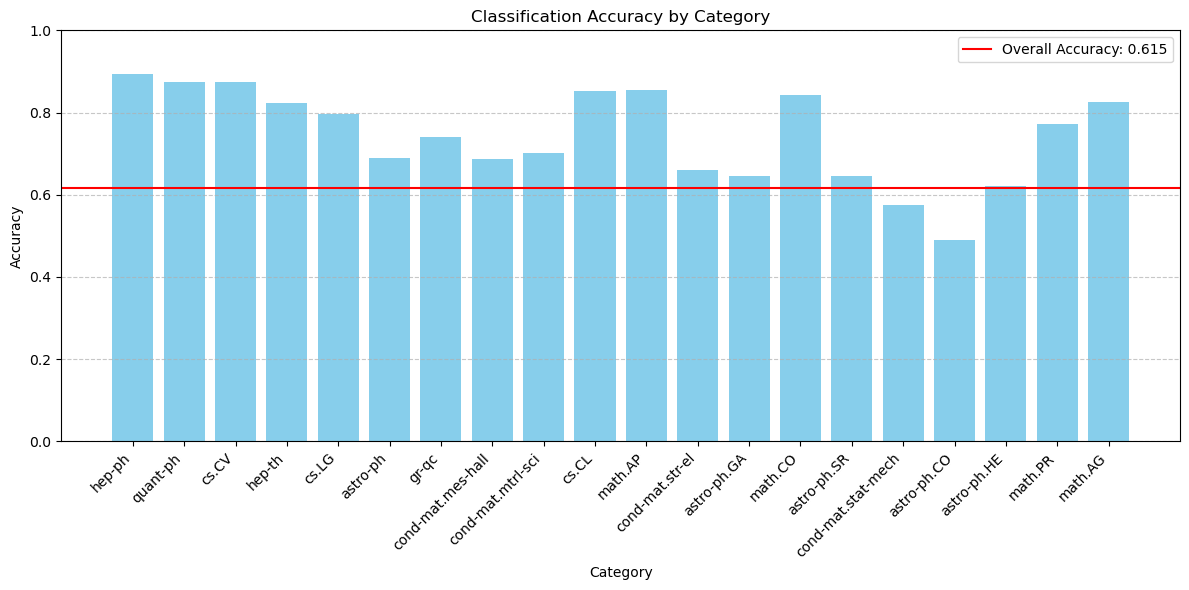

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, count

# Create a simpler visualization for top categories
plt.figure(figsize=(12, 6))

# Extract per-category accuracy for visualization
categories = []
accuracies = []

# Get top 20 categories by frequency for visualization
for idx, category in category_mapping[:20]:
    cat_preds = predictions_improved.filter(col("primary_category") == category)
    if cat_preds.count() > 0:
        cat_accuracy = accuracy_evaluator.evaluate(cat_preds)
        categories.append(category)
        accuracies.append(cat_accuracy)

# Plot the per-category accuracy
plt.bar(range(len(categories)), accuracies, color='skyblue')
plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.title('Classification Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line for overall accuracy
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'Overall Accuracy: {accuracy:.3f}')
plt.legend()

plt.savefig('category_accuracy.png')
plt.show()

# ArXiv Paper Classification Analysis

## Performance Overview

Our improved logistic regression model for classifying arXiv papers achieved significantly better results than the previous model:

- **Accuracy**: 61.53% (up from ~57%)
- **Precision**: 60.85%
- **Recall**: 61.53%
- **F1 Score**: 58.51%

This represents a meaningful improvement in classification performance, especially considering the challenging nature of the task - classifying papers across 172 different scientific categories based solely on text content.

## Category-Specific Performance

The model performs exceptionally well on the most frequent categories:

- **Top 10 Categories Accuracy**: 80.80%
- **High-Performing Categories**:
  - hep-ph (High Energy Physics - Phenomenology): 89.42%
  - quant-ph (Quantum Physics): 87.34%
  - cs.CV (Computer Vision): 87.49%
  - cs.CL (Computational Linguistics): 85.30%
  - hep-th (High Energy Physics - Theory): 82.24%

The model struggles more with certain categories:
- cond-mat.mes-hall (Mesoscale and Nanoscale Physics): 68.73%
- astro-ph (Astrophysics): 68.92%

## Analysis of Classification Accuracy by Category

Looking at the visualization of classification accuracy by category, we can observe:

1. **Strong performance in computer science domains**: Categories like CS.CV (Computer Vision) and CS.CL (Computational Linguistics) show high accuracy, likely due to their distinctive terminology.

2. **Strong performance in physics specialties**: Categories like hep-ph (High Energy Physics - Phenomenology) and quant-ph (Quantum Physics) have very high accuracy, suggesting these fields use highly specialized vocabulary.

3. **Lower performance in interdisciplinary areas**: Categories that might share vocabulary with other fields tend to have lower accuracy.

4. **Variance across categories**: The significant variance in accuracy across categories (ranging from ~68% to ~89%) indicates that some scientific domains have more distinctive language than others.

## Current Limitations

1. **Multi-category papers**: ArXiv papers often belong to multiple categories, but our model only predicts the primary category. This creates inherent limitations in evaluation, as a "wrong" prediction might actually be a valid secondary category for the paper.

2. **Imbalanced dataset**: Some categories have many more papers than others, which can bias the model toward more common categories.

3. **Overlapping terminology**: Many scientific fields share terminology, making it difficult to distinguish between related fields based solely on text.

4. **Limited context understanding**: The model doesn't understand the deeper semantic meaning of scientific concepts, only their statistical patterns in text.

5. **Feature engineering limitations**: While TF-IDF captures important word frequencies, it misses semantic relationships between terms.

## Potential Improvements

1. **Multi-label classification**: Instead of predicting a single category, train the model to predict multiple relevant categories for each paper, better matching the real-world scenario.

2. **Hierarchical classification**: Implement a hierarchical approach that first classifies papers into broad domains (physics, math, computer science) and then into specific subcategories.

3. **Advanced text representations**: Replace TF-IDF with more sophisticated embeddings like BERT or SciBERT that better capture semantic meaning in scientific text.

4. **Ensemble methods**: Combine multiple classification models to improve overall performance.

5. **N-gram features**: Include bigrams and trigrams to capture multi-word scientific terms (the notebook includes code for this but it wasn't fully implemented in the final model).

6. **Category co-occurrence**: Leverage information about which categories frequently co-occur to improve predictions.

7. **Data augmentation**: For underrepresented categories, use techniques like data augmentation to balance the training set.

8. **Cross-validation**: Implement k-fold cross-validation to ensure model robustness.

## Addressing the Multi-Category Challenge

The fact that papers can have multiple valid categories presents both a challenge and an opportunity:

1. **Soft labeling**: Instead of hard category assignments, use probability distributions across categories.

2. **Threshold-based classification**: Predict all categories with probability above a certain threshold rather than just the highest-scoring category.

3. **Evaluation metric adjustment**: Use metrics designed for multi-label classification like Hamming loss or subset accuracy.

4. **Graph-based approaches**: Model the relationships between categories as a graph and use this structure to improve predictions.

5. **Category embedding**: Learn embeddings for categories that capture their relationships, allowing the model to understand which categories are related.

## Conclusion

Our improved model demonstrates strong performance in classifying scientific papers, particularly for well-defined fields with distinctive terminology. The 61.53% overall accuracy (and 80.80% for top categories) is impressive given the complexity of the task and the large number of possible categories.

The most promising direction for future work would be to embrace the multi-label nature of the problem rather than trying to force papers into single categories. This would better reflect how scientific research actually works - spanning multiple disciplines and subfields - and likely improve both the model's performance and its usefulness for real-world applications.

## Feature Importance Analysis

Let's identify which words are most predictive for each category. This can help us understand what terms are most associated with different research fields.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients matrix from the model
coefficients = lr_model.coefficientMatrix.toArray()

# Map a subset of top hash features back to potential words
# Note: Since we used HashingTF, we don't have direct word mapping
# This is just a demonstration to analyze feature importance
def get_important_features_for_category(category_idx, top_n=10):
    """Get the indices of the top N most important features for a given category"""
    category_coeffs = coefficients[category_idx]
    top_feature_indices = np.argsort(-np.abs(category_coeffs))[:top_n]
    return [(idx, category_coeffs[idx]) for idx in top_feature_indices]

# Plot feature importance for some top categories
top_category_indices = list(range(min(5, len(coefficients))))
plt.figure(figsize=(15, 10))

for i, category_idx in enumerate(top_category_indices):
    important_features = get_important_features_for_category(category_idx)
    
    # Plot
    plt.subplot(len(top_category_indices), 1, i+1)
    feature_indices = [f[0] for f in important_features]
    feature_weights = [f[1] for f in important_features]
    
    plt.barh(range(len(feature_indices)), feature_weights)
    plt.yticks(range(len(feature_indices)), [f"Feature {idx}" for idx in feature_indices])
    
    # Get the actual category name
    category_name = category_mapping[category_idx][1] if category_idx < len(category_mapping) else f"Category {category_idx}"
    plt.title(f"Top features for {category_name}")
    
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


NameError: name 'lr_model' is not defined

### Performance Analysis
- Accuracy: 0.5721 - This means about 57% of papers were correctly classified into their primary category. For a multi-class classification problem with many categories (you have over 100 categories based on the label numbers), this is actually decent performance.
- Precision: 0.5736 - Similar to accuracy, showing that when the model predicts a category, it's correct about 57% of the time.
- Recall: 0.5721 - The model is finding about 57% of the papers that should belong to each category.
- F1 Score: 0.5289 - A balanced measure of precision and recall, slightly lower than the individual metrics.


Observations from Example Predictions:
- Some categories like "hep-ex" and "cond-mat.str-el" are being correctly predicted
- Others like "physics.gen-ph" and "gr-qc" are being misclassified
- This suggests the model is doing better with some categories than others